# Generalization vs. OOD detection

In this notebook, we investigate the trade-off between generalization and OOD detection.

We are not interested in so-called OOD generalization. Instead, we consider i.i.d. training locations $x \sim p(x)$, and want to bound the true risk measured via $p(x)$. To provide such generalization bound, we consider PAC-Bayes bounds.

In [1]:
from argparse import Namespace
from datetime import datetime
from hypnettorch.utils.sim_utils import setup_environment
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared
from scipy import optimize
import sys
from time import time
import torch

# Pretend that notebook is located in base directory of this repo.
curr_dir = os.path.basename(os.path.abspath(os.curdir))
base_dir = os.path.abspath('../..')
if curr_dir == 'pac' and base_dir != sys.path[0]:
    sys.path.insert(0, base_dir)

from data.regression_utils import generate_1d_dataset
from utils.plotting import plot_predictive_distributions_1dr


from IPython.display import display, Markdown, Latex
#display(Markdown('*some markdown* $\phi$'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create output directory and other helpers.
config = Namespace()
config.out_dir = './out/pac/run_' + \
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
config.loglevel_info = False
config.random_seed = 42
config.use_cuda = False # CPU usually faster for simple problems.
config.deterministic_run = True
# Delete file from previous tutorial session:
if os.path.exists(config.out_dir):
    shutil.rmtree(config.out_dir)
device, writer, logger = setup_environment(config, logger_name='pac_logger')

Created output folder ./out/pac/run_2022-01-27_13-58-21.
01/27/2022 01:58:21 PM - INFO - Using cuda: False


## Binary KL

In [2]:
def bin_kl(q, p):
    if q == p:
        return 0

    if q > 0:
        if p == 0:
            return np.inf
        term1 = q * np.log(q / p)
    if q < 1:
        if p == 1:
            return np.inf
        term2 = (1-q) * np.log((1-q)/(1-p))
    
    if q == 0:
        return term2
    elif q == 1:
        return term1
    else:
        return term1 + term2

The inverse binary KL $\text{kl}^{-1}$ is defined as:

$$\text{kl}^{-1}(q, \epsilon) = \max \{ p \in [0, 1]: \text{kl}(q, p) \leq \epsilon \}$$

which according to [Reeb et al.](https://arxiv.org/abs/1810.12263) equals to the unique $p \in [q, 1]$ satisfying $kl(q, p) = \epsilon$.

In [3]:
def bin_kl_inv(q, eps):
    if q == 1 or np.isinf(eps):
        return 1
    
    f = lambda p: bin_kl(q, p) - eps
    
    return optimize.bisect(f, q, 1)

Reproducing Fig. 4 in [Reeb et al.](https://arxiv.org/abs/1810.12263).

In [4]:
q_vals = np.linspace(0, 1, 20)
eps_vals = np.array([0, 0.1, 0.2, 0.5, 1, 2, 5])

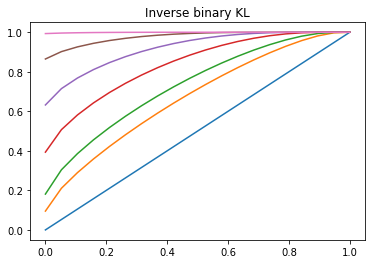

In [5]:
for eps in eps_vals:
    p_vals = []
    for q in q_vals:
        p_vals.append(bin_kl_inv(q, eps))
    p_vals = np.array(p_vals)
    plt.plot(q_vals, p_vals)
plt.title('Inverse binary KL')
plt.show()

## Setup Example GP

In [6]:
pd_plot_kwargs = {
    'sigma_ll': None, #likelihood_var,
    'show_title': False,
    'xticks': [0, 5, 10, 15, 20],
    'yticks': [-2, 0, 2],
    'xlim': [-1, 21],
    'ylim': [-3, 3],
    'show_legend': False,
    'out_dir': config.out_dir,
    'ts': 30,
    'lw': 15,
    'ms': 5,
    'figsize': (6, 4),
    'show_plot': True,
    'vlines': [12.5],
}

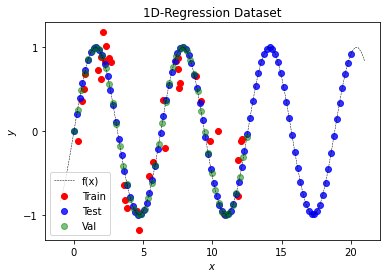

In [7]:
data = generate_1d_dataset(task_id=7, num_train=35,
                           num_val=50, num_test=100, rseed=42)
data.plot_dataset()

X_train_np = data.get_train_inputs()
Y_train_np = data.get_train_outputs()
X_test_np = data.get_test_inputs()
Y_test_np = data.get_test_outputs()
X_val_np = data.get_val_inputs()
Y_val_np = data.get_val_outputs()

# Translate grid to PyTorch tensor.
X_train = torch.from_numpy(X_train_np.astype(np.float32)).to(device)
Y_train = torch.from_numpy(Y_train_np.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test_np.astype(np.float32)).to(device)
Y_test = torch.from_numpy(Y_test_np.astype(np.float32)).to(device)
X_val = torch.from_numpy(X_val_np.astype(np.float32)).to(device)
Y_val = torch.from_numpy(Y_val_np.astype(np.float32)).to(device)

likelihood_var = .3 # Ground-truth

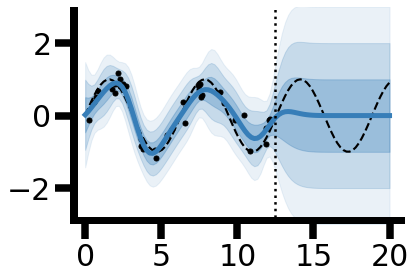

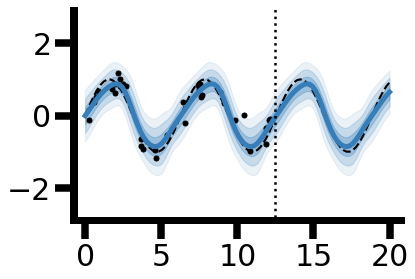

In [8]:
gp_priors_struct = [
    {'type': 'rbf',
     'kernel_params': {'length_scale': 1., 'length_scale_bounds': 'fixed'}},
    {'type': 'ess',
     'kernel_params': {'length_scale': 1.0, 'length_scale_bounds': 'fixed',
                       'periodicity': 6.28, 'periodicity_bounds': 'fixed'}},
]

for pdict in gp_priors_struct:
    if pdict['type'] == 'rbf':
        kernel = RBF(**pdict['kernel_params'])
    elif pdict['type'] == 'ess':
        kernel = ExpSineSquared(**pdict['kernel_params'])
    pdict['kernel'] = kernel
    
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=likelihood_var, 
                                   random_state=42).fit(X_train_np, Y_train_np)
    pdict['gpr_instance'] = gpr
    
    grid_mean, grid_std = gpr.predict(X_test_np, return_std=True)
    grid_samples = gpr.sample_y(X_test_np, n_samples=10).squeeze(1)
    
    plot_predictive_distributions_1dr(data, X_test, pd_samples=None,
            pd_mean=grid_mean, pd_std=grid_std,
            title='GP posterior over functions',
            filename='regression1d_gp_%s' % (pdict['type']), **pd_plot_kwargs)

## Define loss function and average empirical risk

As a loss function we use:

$$l(y, \hat{y}) = 1 - \exp \big\{ - \frac{(y - \hat{y})^2}{\epsilon} \big\}$$

Furthermore, let $p$ be a posterior over hypothesis. The average empirical risk over randomized estimators is defined as

$$R_\text{emp,avg}(p) = \frac{1}{N} \sum_{n=1}^N \mathbb{E}_{h \sim p} [l(y^{(n)}, h(x^{(n)}))]$$

Similarly, the corresponding empirical Bayes risk is defined as

$$R_\text{emp,Bayes}(p) = \frac{1}{N} \sum_{n=1}^N l(y^{(n)}, \mathbb{E}_{h \sim p} [h(x^{(n)})])$$

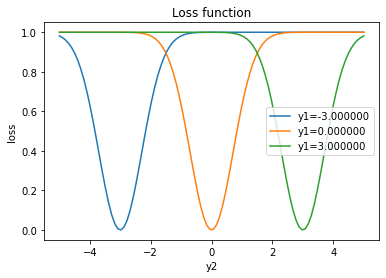

In [9]:
def loss(y1, y2, eps=1):
    return 1 - np.exp(-(y1-y2)**2 / eps)

# Plot loss
y1_vals = np.linspace(-3, 3, 3)
y2_vals = np.linspace(-5, 5, 100)

for y1 in y1_vals:
    l_vals = loss(y1, y2_vals)
    plt.plot(y2_vals, l_vals, label='y1=%f' % y1)
plt.xlabel('y2')
plt.ylabel('loss')
plt.title('Loss function')
plt.legend()
plt.show()

In [10]:
# We need to estimate the expected value over hypotheses via MC sampling.
num_risk_mc = 100

for pdict in gp_priors_struct:
    gpr = pdict['gpr_instance']
    
    train_mean, _ = gpr.predict(X_train_np, return_std=True)
    train_samples = gpr.sample_y(X_train_np, n_samples=num_risk_mc).squeeze(1)

    loss_bayes = loss(Y_train_np, train_mean)
    pdict['r_emp_bayes'] = loss_bayes.mean()
    
    loss_avg = loss(Y_train_np, train_samples).mean(axis=1)
    pdict['r_emp_avg'] = loss_avg.mean()

## Compute PAC bound

Here, we compute the PAC bound according to theorem 1 in [Reeb et al.](https://arxiv.org/abs/1810.12263). Assume a prior $\pi$ and some $\delta \in (0, 1]$:

$$\text{kl}^{-1} \big( R_\text{emp,avg}(p) , \frac{\text{KL}(p,\pi) + \log \frac{2 \sqrt{N}}{\delta}}{N} \big)$$

Note, that the $\text{KL}(p,\pi)$ between Gaussian process prior and posterior can be computed as the KL between the corresponding multivariate Gaussian distributions determining the distribution over function values at training locations.

In [11]:
def kl_mvg(mu1, cov1, mu2, cov2):
    """KL between multivariate Gaussian distributions."""
    k = mu1.size
    
    # Check whether covariance matrices are positive definite.
    if not np.all(np.linalg.eigvals(cov1) > 0):
        display(Markdown('**WARN** Covariance matrix 1 is not positive definite.'))
        cov1 += 1e-5 * np.eye(k)

    if not np.all(np.linalg.eigvals(cov2) > 0):
        display(Markdown('**WARN** Covariance matrix 2 is not positive definite.'))
        cov2 += 1e-5 * np.eye(k)
    
    cov1_det = np.linalg.det(cov1)
    cov2_det = np.linalg.det(cov2)

    with np.errstate(divide='ignore'):
        log_cov1_det = np.log(cov1_det)
        log_cov2_det = np.log(cov2_det)
    
    # This should not occur if we properky convert the
    if np.isnan(log_cov1_det) or np.isinf(log_cov1_det):
        display(Markdown('**WARN** Determinant 1 too small for log.'))
        log_cov1_det = np.log(cov1_det + 1e-5)
    if np.isnan(log_cov2_det) or np.isinf(log_cov2_det):
        display(Markdown('**WARN** Determinant 2 too small for log.'))
        log_cov2_det = np.log(cov2_det + 1e-5)
    
    #cov1_inv = np.linalg.inv(cov1)
    cov2_inv = np.linalg.inv(cov2)
    
    return .5 * (np.trace(cov2_inv @ cov1) + \
                 ((mu2-mu1).T @ cov2_inv @ (mu2-mu1)).squeeze() - \
                 k + log_cov2_det - log_cov1_det)

In [12]:
delta = .05
betas = [1.5, 1.75, 2., 2.25, 2.5] # Required for bound from Germain et al. Corresponds to Alquier's lambda.

for pdict in gp_priors_struct:
    display(Markdown('Kernel: **%s**' % (pdict['type'])))

    kernel = pdict['kernel']
    gpr = pdict['gpr_instance']
    
    N = X_train_np.shape[0]
    
    prior_mu = np.zeros((N, 1))
    prior_cov = kernel(X_train_np, X_train_np)
    
    post_mu, post_cov = gpr.predict(X_train_np, return_cov=True)
    
    kl = kl_mvg(post_mu, post_cov, prior_mu, prior_cov)
    assert kl >= 0 # Might fail due to numerical issues.
    
    ### Compute PAC-bound according to Eq. 4 in Reeb et al. ###
    pac_bound_reeb = bin_kl_inv(pdict['r_emp_avg'], \
                                (kl + np.log(2*np.sqrt(N)/delta)) / N)
    
    ### Compute PAC-bound according to Eq. 1 in Germain et al. ###
    # https://arxiv.org/abs/1605.08636
    pac_bounds_germain = []
    for beta in betas:
        pac_bounds_germain.append(1 / (1-np.exp(-beta)) * (1 - np.exp( \
            -beta * pdict['r_emp_avg'] - 1/N * (kl + np.log(1/delta)))))
    
    ### Compute PAC-bound according to Theorem 2.1 in Alquier. ###
    # https://arxiv.org/abs/2110.11216
    #pac_bound_alquier = pdict['r_emp_avg'] + beta*1**2 / (8*N) + \
    #    (kl + np.log(1/delta)) / beta
    
    ### Compute MSE on validation set ###
    val_mean = gpr.predict(X_val_np)
    val_mse = np.mean((val_mean - Y_val_np)**2)
    
    
    print('Empirical avg. risk: %f' % pdict['r_emp_avg'])
    print('Empirical Bayes risk: %f' % pdict['r_emp_bayes'])
    print('KL-divergence: %f' % kl)
    print('PAC-bound (Reeb et al.) for delta=%f: %f' % (delta, pac_bound_reeb))
    for i, beta in enumerate(betas):
        print('PAC-bound (Germain et al.) for delta=%f, beta=%f: %f' % \
              (delta, beta, pac_bounds_germain[i]))
    #print('PAC-bound (Alquier) for delta=%f, lambda=%f: %f' % (delta, beta, pac_bound_alquier))
    print('Log-marginal likelihood: %f' % (gpr.log_marginal_likelihood()))
    print('MSE on validation set: %f' % (val_mse))
    

Kernel: **rbf**

**WARN** Covariance matrix 1 is not positive definite.

**WARN** Covariance matrix 2 is not positive definite.

Empirical avg. risk: 0.102402
Empirical Bayes risk: 0.037954
KL-divergence: 8.686840
PAC-bound (Reeb et al.) for delta=0.050000: 0.525307
PAC-bound (Germain et al.) for delta=0.050000, beta=1.500000: 0.496574
PAC-bound (Germain et al.) for delta=0.050000, beta=1.750000: 0.485700
PAC-bound (Germain et al.) for delta=0.050000, beta=2.000000: 0.481610
PAC-bound (Germain et al.) for delta=0.050000, beta=2.250000: 0.481981
PAC-bound (Germain et al.) for delta=0.050000, beta=2.500000: 0.485402
Log-marginal likelihood: -26.778798
MSE on validation set: 0.051791


Kernel: **ess**

**WARN** Covariance matrix 1 is not positive definite.

**WARN** Covariance matrix 2 is not positive definite.

Empirical avg. risk: 0.090405
Empirical Bayes risk: 0.051004
KL-divergence: 6.007535
PAC-bound (Reeb et al.) for delta=0.050000: 0.460418
PAC-bound (Germain et al.) for delta=0.050000, beta=1.500000: 0.418172
PAC-bound (Germain et al.) for delta=0.050000, beta=1.750000: 0.411453
PAC-bound (Germain et al.) for delta=0.050000, beta=2.000000: 0.410221
PAC-bound (Germain et al.) for delta=0.050000, beta=2.250000: 0.412613
PAC-bound (Germain et al.) for delta=0.050000, beta=2.500000: 0.417493
Log-marginal likelihood: -23.234703
MSE on validation set: 0.022964


## Sanity-Check: KL divergence between GP prior and posterior

Let's reconsider the prior $\pi$ and posterior $p$. According to [Reeb et al.](https://arxiv.org/abs/1810.12263), the [KL in function space](https://arxiv.org/abs/2011.09421) $\text{KL}(p,\pi)$ can (for this special space) be computed as $\text{KL}(p(f_N),\pi(f_N))$, where $f_N$ denotes function values at training locations.

$$\text{KL}(p,\pi) = \text{KL}(p(f_N) p(f \mid f_N),\pi(f_N) \pi(f \mid f_N)) =  \text{KL}(p(f_N),\pi(f_N)) + \mathbb{E}_{p(f_N)} [ \text{KL}(p(f \mid f_N),\pi(f \mid f_N)) ]$$

Here, we just show numerically that the last term is actually zero. Note, the KL is non-negative. Thus, if we consistently see that $\text{KL}(p(f \mid f_N),\pi(f \mid f_N)) = 0$ for $f_N \sim p(f_N)$ then we are done.

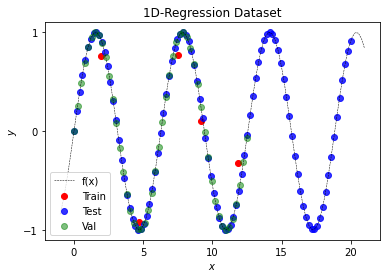

Kernel: **rbf**

Distance between means: 0.000000
KL between conditional distributions: 0.000000


Kernel: **ess**

Distance between means: 0.000000
KL between conditional distributions: -0.000000


In [13]:
# Use new dataset with less training points due to numerical stability.
data2 = generate_1d_dataset(task_id=7, num_train=5,
                            num_val=50, num_test=100)
data2.plot_dataset()

X_train_np2 = data2.get_train_inputs()
Y_train_np2 = data2.get_train_outputs()

# Get a random validation batch.
n_val = 10
n_train = data2.num_train_samples
bval_X, bval_Y = data2.next_val_batch(n_val)

# Concat with training set.
X_all = np.concatenate([bval_X, X_train_np2], axis=0)

for pdict in gp_priors_struct:
    display(Markdown('Kernel: **%s**' % (pdict['type'])))
    
    if pdict['type'] == 'rbf':
        kernel = RBF(**pdict['kernel_params'])
    elif pdict['type'] == 'ess':
        kernel = ExpSineSquared(**pdict['kernel_params'])
    
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=likelihood_var, 
                                   random_state=42).fit(X_train_np2, Y_train_np2)
    
    # Compute joint prior and posterior.
    K_all = kernel(X_all)
    pmu_all, pcov_all = gpr.predict(X_all, return_cov=True)
    
    # Sample random function values f_N.
    f_N = gpr.sample_y(X_train_np2, n_samples=1).squeeze(1)
    
    # Compute conditional distributions (see Sec. 8.1.3 in matrix cook book).
    K_val = K_all[:n_val, :n_val]
    K_train = K_all[n_val:, n_val:]
    K_cross = K_all[:n_val, n_val:]
    
    m_val = pmu_all[:n_val]
    m_train = pmu_all[n_val:]
    C_val = pcov_all[:n_val, :n_val]
    C_train = pcov_all[n_val:, n_val:]
    C_cross = pcov_all[:n_val, n_val:]
    
    prior_cond_mu = K_cross @ np.linalg.inv(K_train) @ f_N
    post_cond_mu = m_val + C_cross @ np.linalg.inv(C_train) @ (f_N - m_train)
    
    print('Distance between means: %f' % np.sum((prior_cond_mu - post_cond_mu)**2))
    
    prior_cond_cov = K_val - K_cross @ np.linalg.inv(K_train) @ K_cross.T
    post_cond_cov = C_val - C_cross @ np.linalg.inv(C_train) @ C_cross.T
    
    kl_cond = kl_mvg(post_cond_mu, post_cond_cov, prior_cond_mu, prior_cond_cov)
    print('KL between conditional distributions: %f' % (kl_cond))